$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc qiskit-ibm-transpiler[ai-local-mode]

# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_summary.md).

## Part II - General Algorithm for Quantum Galton Box

In [2]:
from typing import List, Tuple

import math
import numpy as np

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from circuit_runner import RunMode, run_simulation
from distributions import DistributionType

In [3]:
SHOTS = 4096
ENABLE_REAL_DEVICE = True
results = {}

In [4]:
def calculate_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    start, finish = middle - level, middle + level
    return [(i, i + 1) for i in range(start, finish)]

def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        """Apply the quantum pegs operation for the Galton Board."""
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)


    def levels(qc: QuantumCircuit):
        """Apply the quantum pegs for each level of the Galton Board."""
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        """Final measurement of tally qubits"""
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [5]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

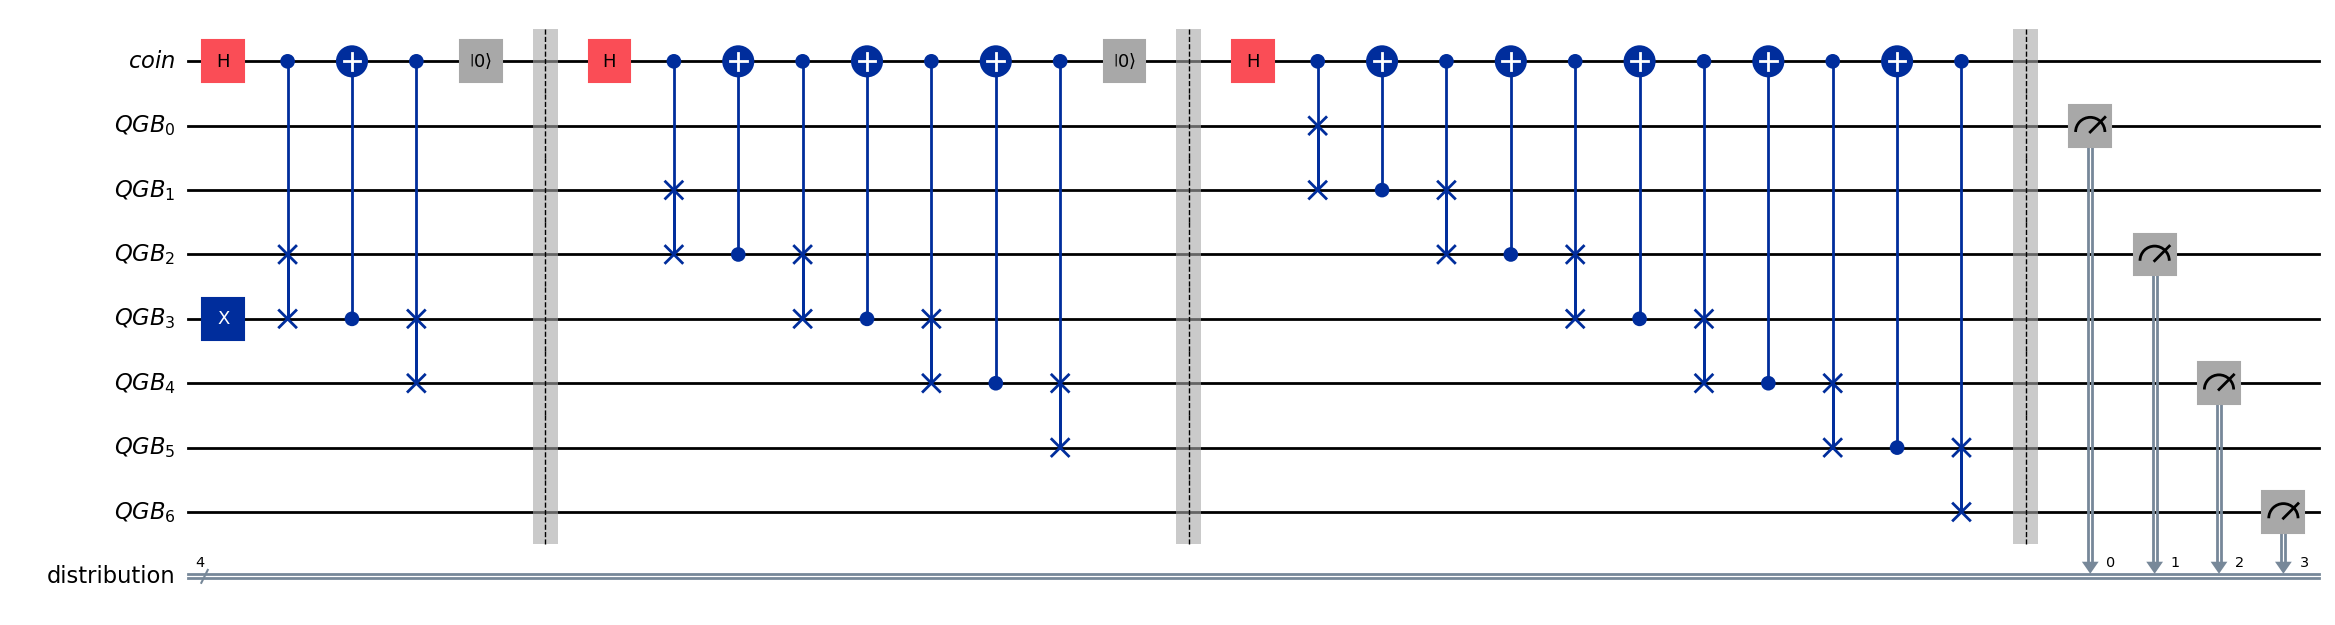

In [6]:
qc = create_qgb_circuit(3, hadamard_coin)
qc.draw("mpl", fold=-1)

In the circuit_runner.py helper module, we defined a function that will run the appropriate simulation of our circuit. It will leverage CircuitRunner class to execute the circuits, get the results and plot them against the reference distribution. `DistributionGenerator` class is used to calculate the perfect case of reference distributions. It supports normal, exponential, hadamard random walk and uniform distribution generation.

Width and depth of transpiled circuit: 21, 90


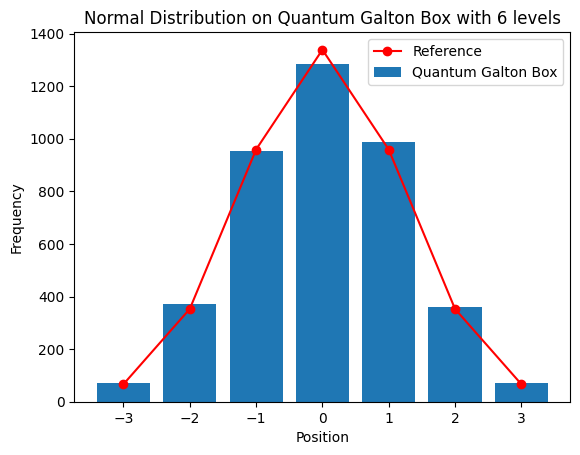

In [7]:
n = 6
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    DistributionType.NORMAL,
    f"Normal Distribution on Quantum Galton Box with {n} levels",
)

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

Width and depth of transpiled circuit: 21, 90


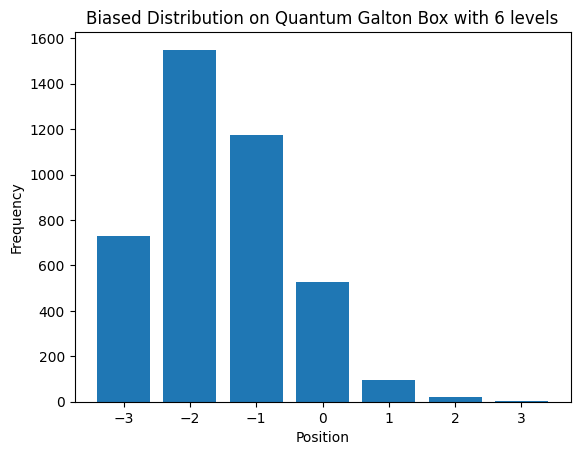

In [8]:
coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
n = 6
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    coin_function,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Biased Distribution on Quantum Galton Box with {n} levels",
    show_reference=False,
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [9]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

Width and depth of transpiled circuit: 21, 120


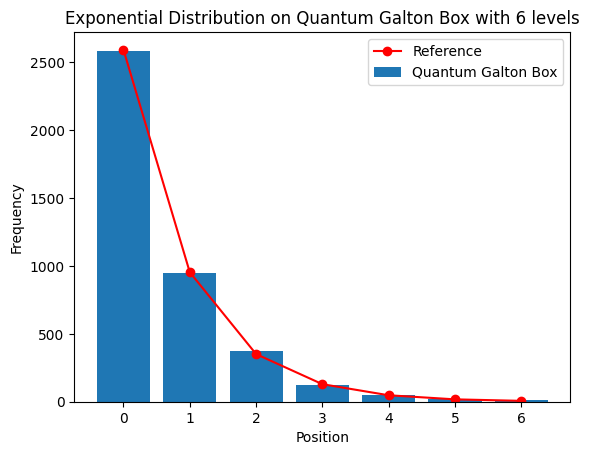

In [10]:
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution on Quantum Galton Box with {n} levels",
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [11]:
def calculate_hrw_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        print(len(wire_tuples))
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

2
4
6


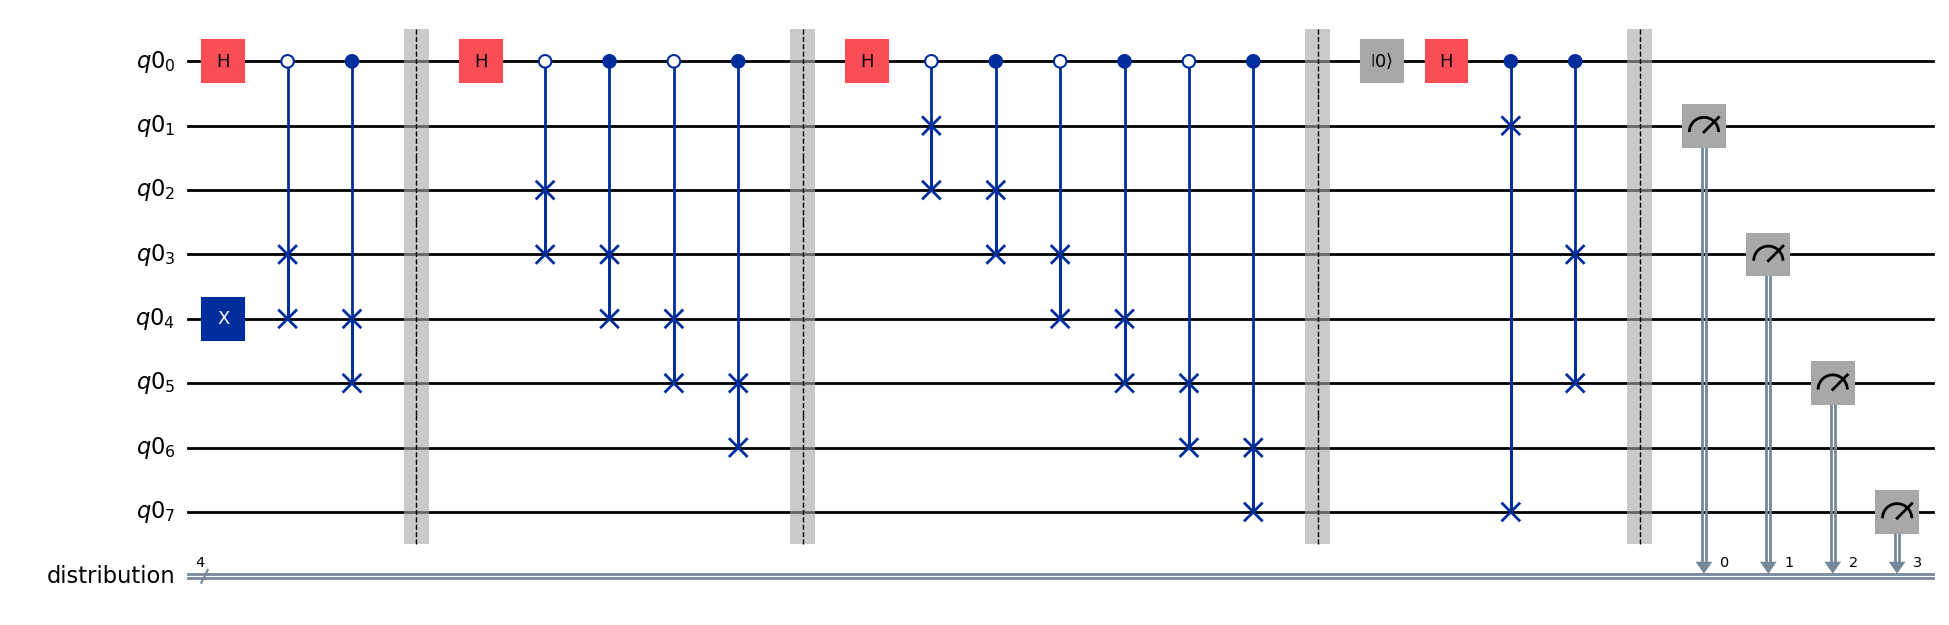

In [12]:
circuit = create_hrw_qgb_circuit(3, hadamard_coin)
circuit.draw("mpl", fold=-1)

2
4
6
8
10
12
Width and depth of transpiled circuit: 21, 90


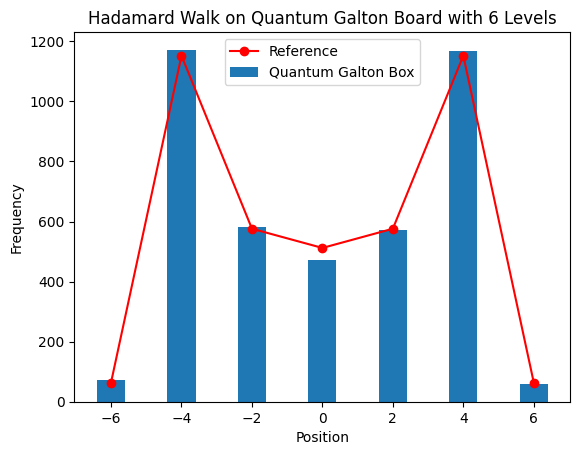

In [13]:
n = 6
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

In [14]:
service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
real_brisbane = service.backend("ibm_brisbane")
print(real_torino.num_qubits, real_brisbane.num_qubits)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-26 14:37:18,669: Default instance not set. Searching all available instances.


133 127


### Gaussian Distribution

We will now execute our Galton Board on a noisy simulator. We will see that it produces a similar to Normal distribution. Due to the noise, the qubits responsible for tails of the distribution are getting diminishing amplitudes and it coincides with the form resembling the Gaussian.

Width and depth of transpiled circuit: 140, 1875
Width and depth after AI Pass: 140, 1760


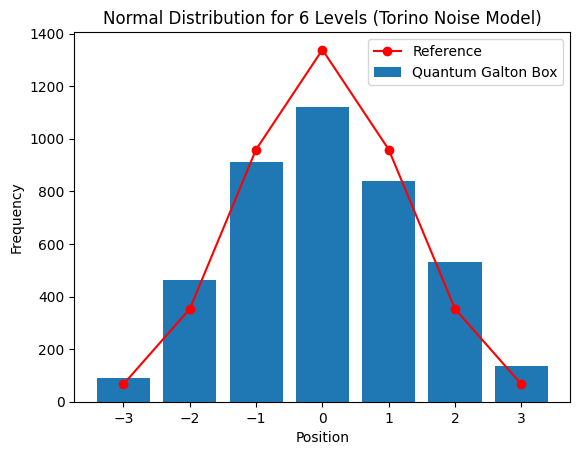

In [15]:
n = 6
results["gaussian_noisy"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISY_SIMULATOR,
    title=f"Normal Distribution for {n} Levels (Torino Noise Model)",
    backend=real_torino,
)

We can also run the same circuit on a real device.

Width and depth of transpiled circuit: 138, 899
Width and depth after AI pass: 138, 885


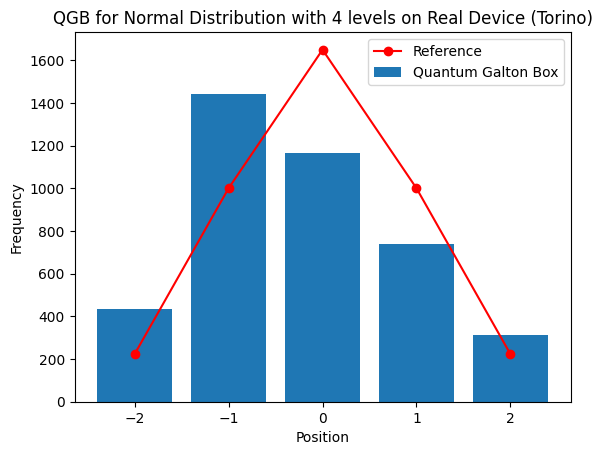

In [16]:
if ENABLE_REAL_DEVICE:
    n = 4
    results["gaussian_real_device"] = run_simulation(
        n,
        SHOTS,
        create_qgb_circuit,
        hadamard_coin,
        RunMode.REAL_DEVICE,
        title=f"QGB for Normal Distribution with {n} levels on Real Device (Torino)",
        backend=real_torino,
    )

### Exponential Distribution

In [17]:
def optimized_exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        qc.cry(theta, level + 1, 0)

In [18]:
def calculate_exp_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level + 2)]


def create_exp_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_exp_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

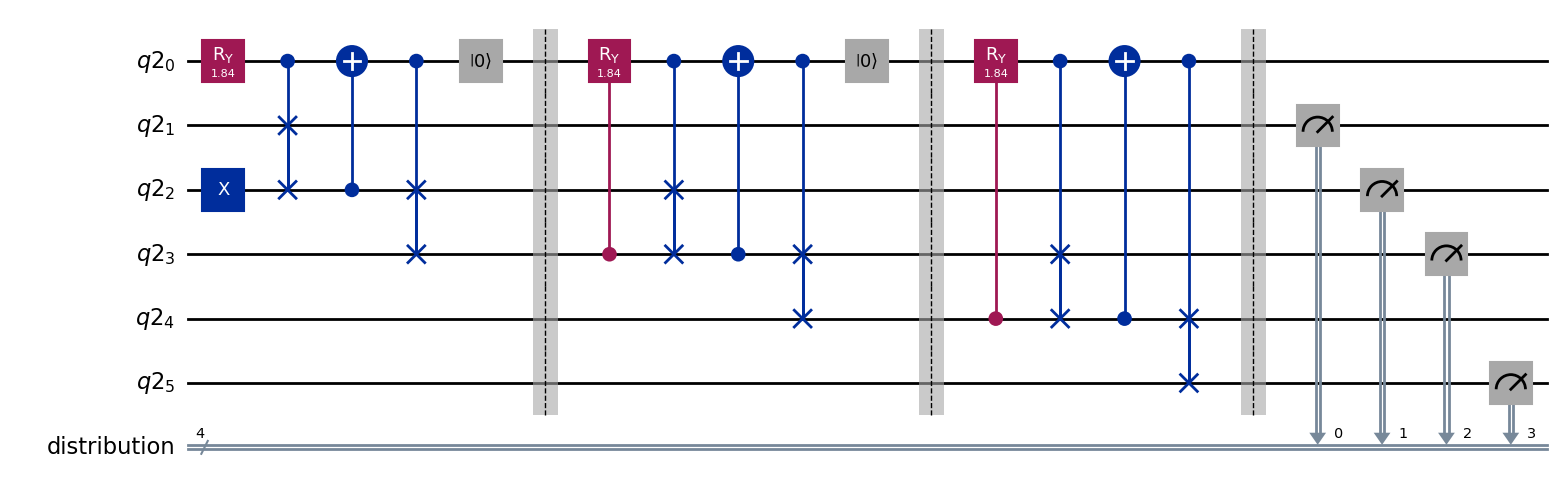

In [19]:
exp_circuit = create_exp_qgb_circuit(3, optimized_exponential_coin)
exp_circuit.draw("mpl", fold=-1)

Without the optimizations, running the circuit under the noise model will produce inaccurate results as shown below.

Width and depth of transpiled circuit: 139, 1528
Width and depth after AI Pass: 139, 1414


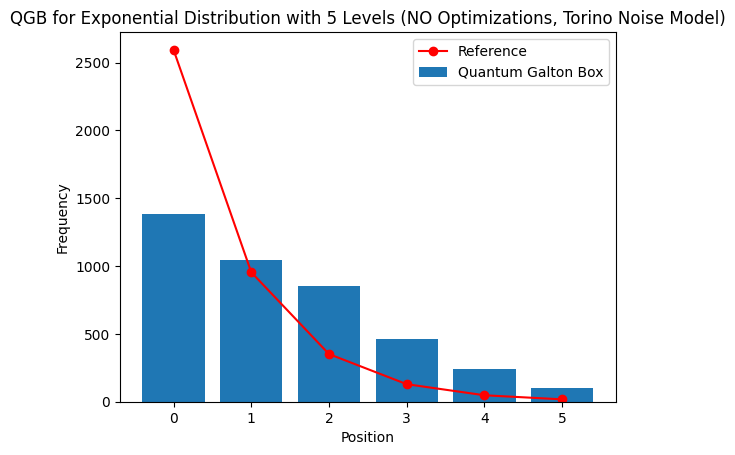

In [20]:
n = 5
results["exponential_noisy"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"QGB for Exponential Distribution with {n} Levels (NO Optimizations, Torino Noise Model)",
    backend=real_torino,
)

Even though we can recognize the diminishing amplitudes, they are far from matching the reference exponential distribution line.

Now, with the suggested optimizations for the exponential distribution on Quantum Galton Board, the results will improve significantly.

Width and depth of transpiled circuit: 139, 425
Width and depth after AI Pass: 139, 401


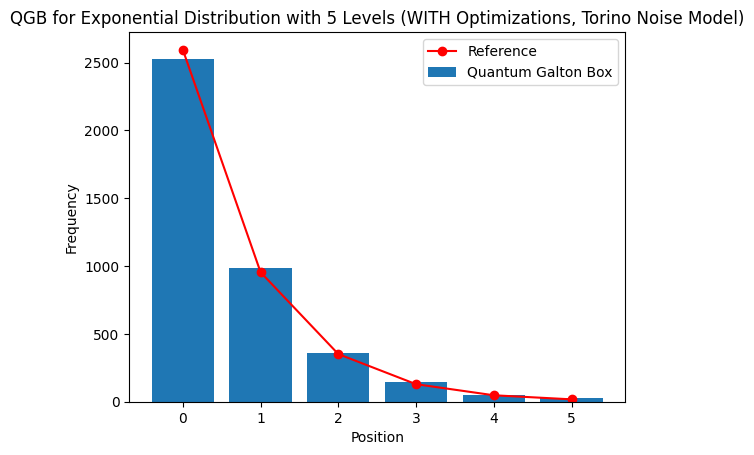

In [21]:
n = 5
results["optimized_exponential_noisy"] = run_simulation(
    n,
    SHOTS,
    create_exp_qgb_circuit,
    optimized_exponential_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"QGB for Exponential Distribution with {n} Levels (WITH Optimizations, Torino Noise Model)",
    backend=real_torino,
)

If you set `ENABLE_REAL_DEVICE = True`, the following cell will run on the real IBM quantum device. In our case, we are choosing `ibm_torino` (same device we used to model the noise).

Width and depth of transpiled circuit: 138, 354
Width and depth after AI pass: 138, 345


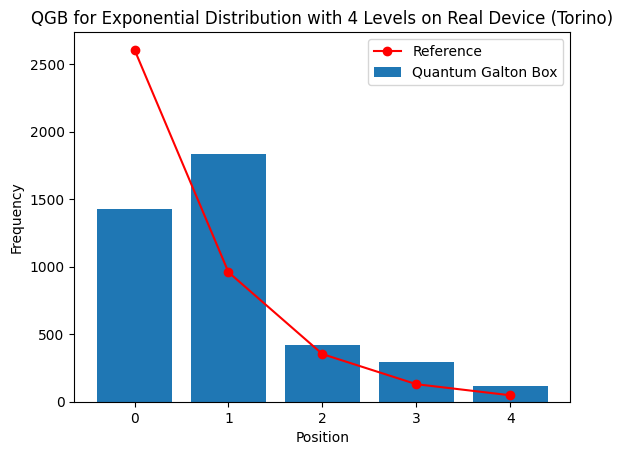

In [22]:
if ENABLE_REAL_DEVICE:
    n = 4
    results["optimized_exponential_real_device"] = run_simulation(
        n,
        SHOTS,
        create_exp_qgb_circuit,
        optimized_exponential_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.EXPONENTIAL,
        title=f"QGB for Exponential Distribution with {n} Levels on Real Device (Torino)",
        backend=real_torino,
    )

### Hadamard Random Walk Distribution

2
4
6
8
Width and depth of transpiled circuit: 138, 926
Width and depth after AI Pass: 138, 953


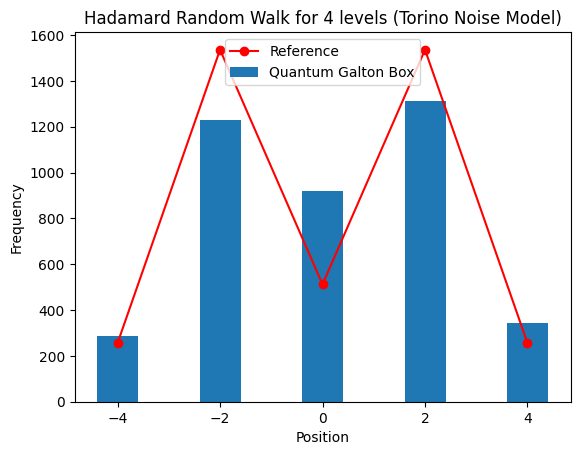

In [23]:
n = 4
results["hadamard_noisy"] = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels (Torino Noise Model)",
    backend=real_torino,
)

2
4
6
8
Width and depth of transpiled circuit: 138, 914
Width and depth after AI pass: 138, 882


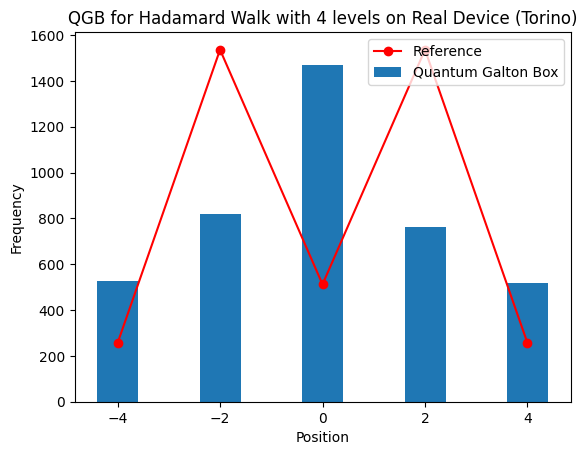

In [24]:
if ENABLE_REAL_DEVICE:
    n = 4
    results["hadamard_real_device"] = run_simulation(
        n,
        SHOTS,
        create_hrw_qgb_circuit,
        hadamard_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.HADAMARD,
        title=f"QGB for Hadamard Walk with {n} levels on Real Device (Torino)",
        backend=real_torino,
    )

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [28]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

In [44]:
positions, freqs, ref_freqs = results["optimized_exponential_noisy"]
quantum_freqs = np.array(list(freqs.values()))
reference_freqs = np.array(ref_freqs)
positions = np.array(positions)

quantum_probs = quantum_freqs / quantum_freqs.sum()
reference_probs = reference_freqs / reference_freqs.sum()
distance = wasserstein_distance(
    u_values=positions,
    v_values=positions,
    u_weights=quantum_probs,
    v_weights=reference_probs
)
print(f"Wasserstein Distance: {distance:.4f}")

Wasserstein Distance: 0.0356


## Part VI - Bonus Section - Uniform Distribution

In [27]:
positions, freqs, ref_freqs

(array([0, 1, 2, 3, 4, 5]),
 {'000001': 1387.5855646100117,
  '000010': 1044.2654249126892,
  '000100': 855.9161816065192,
  '001000': 464.9126891734575,
  '010000': 240.80093131548313,
  '100000': 102.51920838183935},
 [2595.5996572619647,
  954.8677514183189,
  351.27621478440284,
  129.22729759170568,
  47.54006602213235,
  17.489012921475524])

Fairly often, we find it useful to create a uniform superposition of states. It is straightforward to achieve such a distribution across ALL computational basis states by simply applying the Hadamard gates to all qubits.

In this work, leveraging the Galton Board paradigm, we are arriving at an entangled state of $n + 1$ qubits. Our superposition only contains states with a single qubit in $\ket{1}$ state, while all others are $\ket{0}$. Phrased differently only power of 2 computational states are participating: $\ket{2^0}, \ket{2^1}, ..., \ket{2^n}$ for n level quantum galton board. As an example for Galton Board with $n=3$ ($4=n+1$ tally qubits), the superposition will look as below:

$\alpha \ket{0001} + \beta \ket{0010} +\gamma \ket{0100} + \delta \ket{1000}$

By carefully crafting the probabilities of each level, we can generate a uniform superposition of the above mention states. Later, such a superposition, if prepared accurately, can be leveraged as a subroutine in various quantum algorithms.

Moreover, it is possible to reduce the number of qubits and gates count required. Due to the importance of the Uniform distribution, we added the implementation to this work and included the efficient circuit that can be executed on physical devices with fair amount of accuracy.

In [ ]:
def uniform_distribution_coin(qc: QuantumCircuit, n, level):
    """Applies an appropriate coin rotation based on the level."""
    if level % 2 == 1:
        p = 0.5
    else:
        p = 2 / (n + 3 - level)
    theta = 2 * math.acos(np.sqrt(p))
    opp_theta = 2 * math.asin(np.sqrt(p))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        if level % 2 == 1:
            for i in range(middle - level + 1, middle):
                qc.cx(i, 0)
            qc.cry(theta, middle, 0)
        else:
            for i in range(middle - level + 1, middle - 1):
                qc.cx(i, 0)
            qc.cry(theta, middle + 1, 0)
            qc.cry(opp_theta, middle - 1, 0)

In [ ]:
def create_uniform_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

Noiseless simulation:

In [ ]:
n = 5
run_simulation(
    n,
    SHOTS,
    create_uniform_qgb_circuit,
    uniform_distribution_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.UNIFORM,
    title=f"Uniform Distribution for {n} levels (Noiseless)",
)

Noisy Simulation:

In [ ]:
n = 2
run_simulation(
    n,
    SHOTS,
    create_uniform_qgb_circuit,
    uniform_distribution_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.UNIFORM,
    title=f"Uniform Distribution for {n} levels (Torino Noise Model)",
    backend=real_torino,
)